In [15]:
import numpy as np
import pandas as pd
from scipy.special import expit
import random
import os
import gc
import math
import optuna
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.manifold import TSNE
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from geomloss import SamplesLoss
from torch.autograd import Function
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.functional import normalize
#from torchmetrics.classification import BinaryAccuracyS
from torchmetrics.classification import BinaryF1Score,BinaryAccuracy
from sklearn.preprocessing import StandardScaler
torch.manual_seed(42)

In [16]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [17]:
def get_data(train_rate = 0.8):

    ori_data = np.loadtxt("Dataset/Twins/Twin_Data.csv", delimiter=",",skiprows=1)

    # Define features
    x = ori_data[:,:30]
    no, dim = x.shape
    potential_y = ori_data[:, 30:]
    # Die within 1 year = 1, otherwise = 0
    potential_y = np.array(potential_y < 9999,dtype=float) 
    ## Assign treatment
    coef = np.random.uniform(-0.01, 0.01, size = [dim,1])
    prob_temp = expit(np.matmul(x, coef) + np.random.normal(0,0.01, size = [no,1]))

    prob_t = prob_temp/(2*np.mean(prob_temp))
    prob_t[prob_t>1] = 1

    t = np.random.binomial(1,prob_t,[no,1])
    t = t.reshape([no,])
    y = np.zeros([no,1])
    y = np.transpose(t) * potential_y[:,1] + np.transpose(1-t) * potential_y[:,0]    
    y = np.reshape(np.transpose(y), [no, ])
    idx = np.random.permutation(no)
    train_idx = idx[:int(train_rate * no)]
    test_idx = idx[int(train_rate * no):]

    train_x = x[train_idx,:]
    # Normalization here
    #data_mean = np.mean(train_x, axis=0, keepdims=True)
    #data_std = np.std(train_x, axis=0, keepdims=True)

    #train_x = (train_x - data_mean) / data_std
    
    train_t = t[train_idx]
    train_y = pd.DataFrame(y[train_idx])
    train_potential_y = pd.DataFrame(potential_y[train_idx,:])

    test_x = x[test_idx,:]
    # Normalization here
    #test_x = (test_x - data_mean) / data_std
    
    test_x = pd.DataFrame(test_x)
    test_potential_y = pd.DataFrame(potential_y[test_idx,:])
    
    x_data=pd.DataFrame(train_x)
    t_data=pd.DataFrame(train_t)
    df_x_and_t=pd.concat([t_data,x_data],1)
    

    col=["treatment"]
    for i in range(1,31):
        col.append("x"+str(i)) 

    df_x_and_t.columns = col
    
    
    #return train_x, train_t, train_y, train_potential_y, test_x, test_potential_y
    return df_x_and_t,train_y,train_potential_y,test_x,test_potential_y

In [18]:
#train_x,train_y,train_potential_y,test_x,test_potential_y=get_data()

In [19]:
def get_dataloader(x_data,y_data,batch_size):

    x_train_sr=x_data[x_data['treatment']==0]
    y_train_sr=y_data[x_data['treatment']==0]
    x_train_tr=x_data[x_data['treatment']==1]
    y_train_tr=y_data[x_data['treatment']==1]


    train_data_sr = Data(np.array(x_train_sr), np.array(y_train_sr))
    train_dataloader_sr = DataLoader(dataset=train_data_sr, batch_size=batch_size)

    train_data_tr = Data(np.array(x_train_tr), np.array(y_train_tr))
    train_dataloader_tr = DataLoader(dataset=train_data_tr, batch_size=batch_size)


    return train_dataloader_sr, train_dataloader_tr

In [20]:
def regression_loss(concat_true, concat_pred):
    #computes a standard MSE loss for TARNet
    y_true = concat_true[:, 0] #get individual vectors
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    #Each head outputs a prediction for both potential outcomes
    #We use t_true as a switch to only calculate the factual loss
    loss0 = torch.sum((1. - t_true) * torch.square(y_true - y0_pred))
    loss1 = torch.sum(t_true * torch.square(y_true - y1_pred))
    #note Shi uses tf.reduce_sum for her losses instead of tf.reduce_mean.
    #They should be equivalent but it's possible that having larger gradients accelerates convergence.
    #You can always try changing it!
    return loss0 + loss1

In [21]:
def loss_cal(X_data,y_data,net,alpha):
    b_accu = BinaryAccuracy()
    b_f1=BinaryF1Score()
    
    x_train_sr=X_data[X_data['treatment']==0]
    y_train_sr=y_data[X_data['treatment']==0]
    x_train_tr=X_data[X_data['treatment']==1]
    y_train_tr=y_data[X_data['treatment']==1]
    xs_t=x_train_sr.iloc[:,0].to_numpy()
    xt_t=x_train_tr.iloc[:,0].to_numpy()
    
    
    xs=x_train_sr.iloc[:,1:31].to_numpy()
    xt=x_train_tr.iloc[:,1:31].to_numpy()
    xs_t=torch.from_numpy(xs_t.astype(np.float32))
    xt_t=torch.from_numpy(xt_t.astype(np.float32))
    y_train_sr=y_train_sr.to_numpy()
    y_train_tr=y_train_tr.to_numpy()
    xs=torch.from_numpy(xs.astype(np.float32))
    xt=torch.from_numpy(xt.astype(np.float32))
    
    y_train_sr=torch.from_numpy(y_train_sr.astype(np.float32))
    y_train_tr=torch.from_numpy(y_train_tr.astype(np.float32))
    
    
    input_data=torch.cat((xs,xt),0)
    #true_y=torch.unsqueeze(torch.cat((y_train_sr,y_train_tr),0), dim=1)
    true_y=torch.cat((y_train_sr,y_train_tr),0)
    true_t=torch.unsqueeze(torch.cat((xs_t,xt_t),0), dim=1)
    
    
    concat_true=torch.cat((true_y,true_t),1)
    concat_pred,d_out,phi=net(input_data,alpha)
    loss=regression_loss(concat_true, concat_pred)
    
    
    
    t_actual=torch.cat((xs_t.type(torch.LongTensor),xt_t.type(torch.LongTensor)),0)
    
    domain_loss=criterion(d_out, t_actual)
    
    predicted = torch.argmax(d_out, dim=1)
    
    
    
    
    return domain_loss.item(),loss.item(),b_accu(predicted, t_actual.squeeze()),b_f1(predicted, t_actual.squeeze())

In [22]:
def objective(trial,i,x_data,y_data):

    params = {
          'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
          'batch_size':trial.suggest_int('batch_size', 8, 256),
          'RL11':trial.suggest_int('RL11', 16, 512),
          'RL21': trial.suggest_int('RL21', 16, 512),
          'RL32': trial.suggest_int('RL32', 16, 512),
          'RG012':trial.suggest_int('RG012', 16, 512),
        'RG022':trial.suggest_int('RG022', 16, 512),
        'RG112':trial.suggest_int('RG112', 16, 512),
        'RG122':trial.suggest_int('RG122', 16, 512),
        'CL12':trial.suggest_int('CL12', 16, 512),
        'CL22':trial.suggest_int('CL22', 16, 512)
          
          }

    model = TarNet(params)

    pehe,model= train_evaluate(params, model, trial,i,x_data,y_data)

    return pehe

In [23]:
# PEHE evaluation
def cal_pehe(data,y,model, alpha=0.5):
    #data,y=get_data('test',i)

    data=data.to_numpy()
    data=torch.from_numpy(data.astype(np.float32))
    
    y=y.to_numpy()
    y=torch.from_numpy(y.astype(np.float32))



    concat_pred,d_out,phi=model(data[:,0:30])
    #dont forget to rescale the outcome before estimation!
    #y0_pred = data['y_scaler'].inverse_transform(concat_pred[:, 0].reshape(-1, 1))
    #y1_pred = data['y_scaler'].inverse_transform(concat_pred[:, 1].reshape(-1, 1))
    #y0=scaler.inverse_transform(concat_pred[:,0].reshape(-1, 1))
    #y1=scaler.inverse_transform(concat_pred[:,1].reshape(-1, 1))
    cate_pred=concat_pred[:,1]-concat_pred[:,0]
    #cate_pred=y1-y0
    
    #cate_true=data[:,4]-data[:,3] #Hill's noiseless true values
    cate_true=y[:,1] - y[:,0]


    cate_err=torch.mean( torch.square( ( (cate_true) - (cate_pred) ) ) )

    return torch.sqrt(cate_err).item()

In [24]:
class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(30, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL32'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], 2), #params['CL22']
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], params['RG022']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], params['RG122']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        y1 = self.regressorO_y1(out_y1)

        #concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        #d_out = self.dis3_d(out_d2)

        concat = torch.cat((y0, y1), 1)
        return concat,out_d2,phi

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None


In [25]:
epochs=300
#batch_size=32
criterion = nn.CrossEntropyLoss()
#x_data,y_data=get_data(0.9)

#criterion =nn.BCELoss()

In [26]:
train_loss=[]
val_loss=[]
train_accu=[]
val_accu=[]
val_f1=[]
train_f1=[]
train_tloss=[]
val_tloss=[]

d_loss=[]
pehe_error=[]
#num_files=2
def train_evaluate(param, model, trial,file_num,x_data,y_data):
    #for nf in range(1,num_files):
    X_train, X_val,y_train, y_val = train_test_split(x_data,y_data ,
                                       random_state=42, 
                                       test_size=0.27)
    
    
    
    #net=TarNet(25,.01)
    #opt_net = torch.optim.Adam(net.parameters(), lr=1e-4)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])
    
    if use_cuda:

        #model = model.cuda()
        model = model
        #criterion = criterion
  

    for ep in range(1,epochs+1 ):
        
        lamda_max=5
        e0=20
        train_dataloader_sr, train_dataloader_tr=get_dataloader(X_train,y_train,param['batch_size'])
        
        
        lambda_val=(lamda_max)*((ep-e0)/(epochs-e0))
        alpha=max(0,lambda_val)
        dis_loss=0
        total_loss=0
 
        for batch_idx, (train_source_data, train_target_data) in enumerate(zip(train_dataloader_sr, train_dataloader_tr)):
            
            xs,ys=train_source_data
            xt,yt=train_target_data
            
            xs_train=xs[:,1:31]
            xt_train=xt[:,1:31]
            #alpha=5
            
            train_x=torch.cat((xs_train,xt_train),0)
            #train_y=torch.unsqueeze(torch.cat((ys,yt),0), dim=1)
            train_y=torch.cat((ys,yt),0)
            true_t=torch.unsqueeze(torch.cat((xs[:,0],xt[:,0]),0), dim=1)
            concat_true=torch.cat((train_y,true_t),1)
            concat_pred,d_out,phi=model(train_x,alpha)
            
            
            #s_zeros_t=torch.zeros(xs_train.shape[0],1)
            #t_ones_t=torch.ones(xt_train.shape[0],1)

            #labels=torch.cat((s_zeros_t,t_ones_t),0)
           
            
            labels_discr=torch.cat((xs[:,0].type(torch.LongTensor),xt[:,0].type(torch.LongTensor)),0)
            #outputs_discr = domain_descr(phi,alpha)
            
            model.zero_grad()
            #opt_dis.zero_grad()
            

            #source_mse=criterion_reg(y0,ys)
            #target_mse=criterion_reg(y1,yt)
            domain_loss=criterion(d_out, labels_discr)
            reg_loss=regression_loss(concat_true,concat_pred)
            #combined loss
            combined_loss=domain_loss+reg_loss
            #print('Training loss: ',combined_loss.item())
            # backward propagation
            combined_loss.backward()
            dis_loss= dis_loss+domain_loss.item()
            total_loss=total_loss+combined_loss.item()
            # optimize
            optimizer.step()
            #opt_dis.step()
        #train_loss.append(loss_cal(X_train,y_train,model,alpha))
        #val_loss.append(loss_cal(X_val,y_val,model,alpha))
        d_loss.append(dis_loss)
        d_loss_tr,tr_los,tr_ac,tr_f1=loss_cal(X_train,y_train,model,alpha)
        d_loss_val,vl_los,vl_ac,vl_f1=loss_cal(X_val,y_val,model,alpha)
        train_tloss.append(d_loss_tr)
        train_loss.append(tr_los)
        train_accu.append(tr_ac)
        train_f1.append(tr_f1)
        
        val_loss.append(vl_los)
        val_accu.append(vl_ac)
        val_f1.append(vl_f1)
        val_tloss.append(d_loss_val)
        
        
    #return cal_pehe(X_val,y_val,model),model
    #return total_loss,model
    #return d_loss_val+vl_los,model
    return vl_los,model
    #return cal_pehe_nn(X_val,y_val,model,alpha),model
    


In [27]:
def clear_all():
    train_loss.clear()
    train_accu.clear()
    train_f1.clear()
    val_loss.clear()
    val_accu.clear()
    val_f1.clear()
    d_loss.clear()
    train_tloss.clear()
    val_tloss.clear()
    

In [28]:
pehe_total=[]
trails=50
#i=1
for i in range(1,11):
    x_data,y_data,train_p_y,test_x,test_p_y=get_data(0.9)
    func = lambda trial: objective(trial, i,x_data,y_data)
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(func, n_trials=trails)
    best_trial = study.best_trial
    best_model=TarNet(study.best_trial.params)
    clear_all()
    best_val,model=train_evaluate(study.best_trial.params, best_model, study.best_trial,i,x_data,y_data)
    #data,y=get_data('train',i)
    pehe=cal_pehe(x_data,train_p_y,model)
    print('# of files completed so far:',i)
    pehe_total.append(pehe)
    del best_model
    del model
    del study
    del x_data
    del y_data
    del train_p_y
    del test_x
    del test_p_y
    gc.collect()

/tmp/ipykernel_4817/807057932.py:47: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_x_and_t=pd.concat([t_data,x_data],1)
[I 2023-03-26 12:22:36,828] A new study created in memory with name: no-name-b6dc982b-077e-4e8f-b95a-6c0ab8b12a32
/tmp/ipykernel_4817/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 12:23:29,768] Trial 0 finished with value: 265.0128173828125 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 265.0128173828125.
[I 2023-03-26 12:24:25

[I 2023-03-26 12:50:12,850] Trial 22 finished with value: 260.4502258300781 and parameters: {'learning_rate': 0.00010898521521812961, 'optimizer': 'SGD', 'batch_size': 47, 'RL11': 213, 'RL21': 469, 'RL32': 198, 'RG012': 61, 'RG022': 151, 'RG112': 273, 'RG122': 310, 'CL12': 424, 'CL22': 61}. Best is trial 6 with value: 257.584228515625.
[I 2023-03-26 12:52:53,921] Trial 23 finished with value: 259.703125 and parameters: {'learning_rate': 7.831305640595831e-05, 'optimizer': 'SGD', 'batch_size': 13, 'RL11': 141, 'RL21': 379, 'RL32': 105, 'RG012': 145, 'RG022': 275, 'RG112': 299, 'RG122': 231, 'CL12': 304, 'CL22': 78}. Best is trial 6 with value: 257.584228515625.
[I 2023-03-26 12:54:10,293] Trial 24 finished with value: 256.4896240234375 and parameters: {'learning_rate': 0.00013447059619077639, 'optimizer': 'SGD', 'batch_size': 97, 'RL11': 55, 'RL21': 461, 'RL32': 247, 'RG012': 94, 'RG022': 341, 'RG112': 363, 'RG122': 393, 'CL12': 243, 'CL22': 82}. Best is trial 24 with value: 256.4896240

[I 2023-03-26 13:21:48,029] Trial 45 finished with value: 281.5646667480469 and parameters: {'learning_rate': 0.00014121855019431145, 'optimizer': 'Adam', 'batch_size': 124, 'RL11': 91, 'RL21': 184, 'RL32': 299, 'RG012': 238, 'RG022': 274, 'RG112': 255, 'RG122': 184, 'CL12': 203, 'CL22': 166}. Best is trial 35 with value: 256.2908020019531.
[I 2023-03-26 13:22:33,047] Trial 46 finished with value: 259.8689270019531 and parameters: {'learning_rate': 0.00029126840896803865, 'optimizer': 'SGD', 'batch_size': 197, 'RL11': 181, 'RL21': 441, 'RL32': 144, 'RG012': 195, 'RG022': 299, 'RG112': 354, 'RG122': 78, 'CL12': 239, 'CL22': 222}. Best is trial 35 with value: 256.2908020019531.
[I 2023-03-26 13:23:07,203] Trial 47 finished with value: 259.4239196777344 and parameters: {'learning_rate': 0.00024710570126856607, 'optimizer': 'SGD', 'batch_size': 223, 'RL11': 189, 'RL21': 115, 'RL32': 57, 'RG012': 176, 'RG022': 413, 'RG112': 344, 'RG122': 41, 'CL12': 243, 'CL22': 419}. Best is trial 35 with 

# of files completed so far: 1


/tmp/ipykernel_4817/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 13:26:45,192] Trial 0 finished with value: 237.19390869140625 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 237.19390869140625.
[I 2023-03-26 13:27:43,737] Trial 1 finished with value: 245.78701782226562 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 237.1939086914

[I 2023-03-26 13:54:02,365] Trial 23 finished with value: 240.56558227539062 and parameters: {'learning_rate': 3.961522558955052e-05, 'optimizer': 'SGD', 'batch_size': 142, 'RL11': 210, 'RL21': 140, 'RL32': 178, 'RG012': 416, 'RG022': 447, 'RG112': 325, 'RG122': 468, 'CL12': 355, 'CL22': 327}. Best is trial 6 with value: 235.26983642578125.
[I 2023-03-26 13:55:24,242] Trial 24 finished with value: 240.9346466064453 and parameters: {'learning_rate': 6.960283214009002e-05, 'optimizer': 'Adam', 'batch_size': 181, 'RL11': 88, 'RL21': 16, 'RL32': 146, 'RG012': 505, 'RG022': 380, 'RG112': 455, 'RG122': 418, 'CL12': 324, 'CL22': 96}. Best is trial 6 with value: 235.26983642578125.
[I 2023-03-26 13:56:20,231] Trial 25 finished with value: 241.11309814453125 and parameters: {'learning_rate': 9.983146979243465e-05, 'optimizer': 'SGD', 'batch_size': 159, 'RL11': 418, 'RL21': 60, 'RL32': 224, 'RG012': 442, 'RG022': 288, 'RG112': 247, 'RG122': 147, 'CL12': 433, 'CL22': 157}. Best is trial 6 with va

[W 2023-03-26 14:20:59,110] Trial 45 failed with value nan.
[I 2023-03-26 14:21:59,710] Trial 46 finished with value: 234.23150634765625 and parameters: {'learning_rate': 0.00012878102936566264, 'optimizer': 'SGD', 'batch_size': 248, 'RL11': 362, 'RL21': 300, 'RL32': 195, 'RG012': 508, 'RG022': 419, 'RG112': 412, 'RG122': 65, 'CL12': 340, 'CL22': 240}. Best is trial 46 with value: 234.23150634765625.
[W 2023-03-26 14:22:54,866] Trial 47 failed with parameters: {'learning_rate': 0.0001345531271656469, 'optimizer': 'SGD', 'batch_size': 252, 'RL11': 370, 'RL21': 298, 'RL32': 205, 'RG012': 506, 'RG022': 336, 'RG112': 354, 'RG122': 63, 'CL12': 258, 'CL22': 249} because of the following error: The value nan is not acceptable..
[W 2023-03-26 14:22:54,867] Trial 47 failed with value nan.
[I 2023-03-26 14:23:52,846] Trial 48 finished with value: 234.5139923095703 and parameters: {'learning_rate': 0.00013581478320948053, 'optimizer': 'SGD', 'batch_size': 246, 'RL11': 382, 'RL21': 303, 'RL32': 19

# of files completed so far: 2


/tmp/ipykernel_4817/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 14:26:41,902] Trial 0 finished with value: 246.7317657470703 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 246.7317657470703.
[I 2023-03-26 14:27:40,958] Trial 1 finished with value: 244.6289825439453 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 244.6289825439453

[I 2023-03-26 14:59:19,467] Trial 22 finished with value: 242.2357635498047 and parameters: {'learning_rate': 0.00010904142170059942, 'optimizer': 'SGD', 'batch_size': 100, 'RL11': 338, 'RL21': 299, 'RL32': 265, 'RG012': 40, 'RG022': 341, 'RG112': 334, 'RG122': 268, 'CL12': 429, 'CL22': 97}. Best is trial 13 with value: 240.7703094482422.
[W 2023-03-26 15:00:36,793] Trial 23 failed with parameters: {'learning_rate': 0.000495206208367237, 'optimizer': 'SGD', 'batch_size': 116, 'RL11': 232, 'RL21': 439, 'RL32': 508, 'RG012': 137, 'RG022': 447, 'RG112': 126, 'RG122': 380, 'CL12': 294, 'CL22': 211} because of the following error: The value nan is not acceptable..
[W 2023-03-26 15:00:36,794] Trial 23 failed with value nan.
[W 2023-03-26 15:01:43,633] Trial 24 failed with parameters: {'learning_rate': 0.00046305779506046295, 'optimizer': 'SGD', 'batch_size': 122, 'RL11': 434, 'RL21': 433, 'RL32': 115, 'RG012': 143, 'RG022': 145, 'RG112': 104, 'RG122': 390, 'CL12': 300, 'CL22': 66} because of

[W 2023-03-26 15:19:11,281] Trial 42 failed with value nan.
[W 2023-03-26 15:20:09,620] Trial 43 failed with parameters: {'learning_rate': 0.0005486663574214051, 'optimizer': 'SGD', 'batch_size': 148, 'RL11': 205, 'RL21': 314, 'RL32': 209, 'RG012': 210, 'RG022': 145, 'RG112': 440, 'RG122': 203, 'CL12': 461, 'CL22': 121} because of the following error: The value nan is not acceptable..
[W 2023-03-26 15:20:09,621] Trial 43 failed with value nan.
[W 2023-03-26 15:20:59,957] Trial 44 failed with parameters: {'learning_rate': 0.0009618181029506576, 'optimizer': 'SGD', 'batch_size': 146, 'RL11': 195, 'RL21': 438, 'RL32': 215, 'RG012': 226, 'RG022': 140, 'RG112': 89, 'RG122': 193, 'CL12': 448, 'CL22': 123} because of the following error: The value nan is not acceptable..
[W 2023-03-26 15:20:59,958] Trial 44 failed with value nan.
[I 2023-03-26 15:22:00,438] Trial 45 finished with value: 239.09567260742188 and parameters: {'learning_rate': 0.00017627008369339338, 'optimizer': 'SGD', 'batch_siz

# of files completed so far: 3


/tmp/ipykernel_4817/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 15:27:31,794] Trial 0 finished with value: 263.0118713378906 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 263.0118713378906.
[I 2023-03-26 15:28:31,860] Trial 1 finished with value: 265.65045166015625 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 263.011871337890

[I 2023-03-26 15:59:08,880] Trial 22 finished with value: 257.8126525878906 and parameters: {'learning_rate': 0.00010480572362999926, 'optimizer': 'SGD', 'batch_size': 141, 'RL11': 440, 'RL21': 390, 'RL32': 112, 'RG012': 413, 'RG022': 452, 'RG112': 470, 'RG122': 215, 'CL12': 452, 'CL22': 208}. Best is trial 16 with value: 256.82757568359375.
[I 2023-03-26 16:00:58,153] Trial 23 finished with value: 264.63043212890625 and parameters: {'learning_rate': 0.0005249062074948539, 'optimizer': 'SGD', 'batch_size': 42, 'RL11': 321, 'RL21': 308, 'RL32': 207, 'RG012': 340, 'RG022': 386, 'RG112': 379, 'RG122': 506, 'CL12': 282, 'CL22': 319}. Best is trial 16 with value: 256.82757568359375.
[I 2023-03-26 16:02:18,711] Trial 24 finished with value: 258.2188720703125 and parameters: {'learning_rate': 0.00010260110249438746, 'optimizer': 'SGD', 'batch_size': 142, 'RL11': 434, 'RL21': 391, 'RL32': 99, 'RG012': 505, 'RG022': 458, 'RG112': 458, 'RG122': 198, 'CL12': 444, 'CL22': 190}. Best is trial 16 wi

[W 2023-03-26 16:19:51,188] Trial 42 failed with value nan.
[W 2023-03-26 16:20:48,134] Trial 43 failed with parameters: {'learning_rate': 0.00020464076235167215, 'optimizer': 'SGD', 'batch_size': 241, 'RL11': 315, 'RL21': 510, 'RL32': 280, 'RG012': 219, 'RG022': 351, 'RG112': 312, 'RG122': 75, 'CL12': 408, 'CL22': 93} because of the following error: The value nan is not acceptable..
[W 2023-03-26 16:20:48,135] Trial 43 failed with value nan.
[W 2023-03-26 16:21:46,281] Trial 44 failed with parameters: {'learning_rate': 0.0002033590374589571, 'optimizer': 'SGD', 'batch_size': 247, 'RL11': 313, 'RL21': 510, 'RL32': 280, 'RG012': 291, 'RG022': 355, 'RG112': 305, 'RG122': 42, 'CL12': 403, 'CL22': 96} because of the following error: The value nan is not acceptable..
[W 2023-03-26 16:21:46,282] Trial 44 failed with value nan.
[W 2023-03-26 16:22:46,173] Trial 45 failed with parameters: {'learning_rate': 0.00022879320376286723, 'optimizer': 'SGD', 'batch_size': 251, 'RL11': 327, 'RL21': 511,

# of files completed so far: 4


/tmp/ipykernel_4817/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 16:28:29,519] Trial 0 finished with value: 251.89613342285156 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 251.89613342285156.
[I 2023-03-26 16:29:26,805] Trial 1 finished with value: 251.3589324951172 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 251.35893249511

[I 2023-03-26 16:59:07,518] Trial 23 finished with value: 252.46441650390625 and parameters: {'learning_rate': 3.2568563113046444e-05, 'optimizer': 'SGD', 'batch_size': 56, 'RL11': 411, 'RL21': 346, 'RL32': 216, 'RG012': 446, 'RG022': 373, 'RG112': 268, 'RG122': 45, 'CL12': 312, 'CL22': 146}. Best is trial 12 with value: 247.73016357421875.
[I 2023-03-26 17:00:10,012] Trial 24 finished with value: 251.2276611328125 and parameters: {'learning_rate': 2.1066584681913617e-05, 'optimizer': 'SGD', 'batch_size': 138, 'RL11': 339, 'RL21': 508, 'RL32': 140, 'RG012': 230, 'RG022': 281, 'RG112': 349, 'RG122': 113, 'CL12': 455, 'CL22': 208}. Best is trial 12 with value: 247.73016357421875.
[I 2023-03-26 17:01:28,065] Trial 25 finished with value: 254.56915283203125 and parameters: {'learning_rate': 3.909652091955379e-05, 'optimizer': 'SGD', 'batch_size': 89, 'RL11': 307, 'RL21': 405, 'RL32': 286, 'RG012': 398, 'RG022': 468, 'RG112': 114, 'RG122': 181, 'CL12': 266, 'CL22': 25}. Best is trial 12 wit

[I 2023-03-26 17:32:34,310] Trial 47 finished with value: 252.93099975585938 and parameters: {'learning_rate': 1.940766709303691e-05, 'optimizer': 'SGD', 'batch_size': 69, 'RL11': 282, 'RL21': 65, 'RL32': 249, 'RG012': 312, 'RG022': 422, 'RG112': 409, 'RG122': 123, 'CL12': 367, 'CL22': 374}. Best is trial 29 with value: 247.52662658691406.
[I 2023-03-26 17:33:21,518] Trial 48 finished with value: 247.57012939453125 and parameters: {'learning_rate': 4.3975340329044905e-05, 'optimizer': 'SGD', 'batch_size': 123, 'RL11': 201, 'RL21': 19, 'RL32': 28, 'RG012': 98, 'RG022': 203, 'RG112': 289, 'RG122': 154, 'CL12': 474, 'CL22': 330}. Best is trial 29 with value: 247.52662658691406.
[I 2023-03-26 17:34:26,319] Trial 49 finished with value: 250.65518188476562 and parameters: {'learning_rate': 4.4113786237433296e-05, 'optimizer': 'SGD', 'batch_size': 124, 'RL11': 161, 'RL21': 52, 'RL32': 358, 'RG012': 88, 'RG022': 192, 'RG112': 286, 'RG122': 218, 'CL12': 463, 'CL22': 449}. Best is trial 29 with 

# of files completed so far: 5


/tmp/ipykernel_4817/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 17:36:41,002] Trial 0 finished with value: 236.23065185546875 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 236.23065185546875.
[I 2023-03-26 17:37:39,738] Trial 1 finished with value: 243.26004028320312 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 236.2306518554

[W 2023-03-26 18:07:23,150] Trial 21 failed with value nan.
[W 2023-03-26 18:08:16,423] Trial 22 failed with parameters: {'learning_rate': 0.00042720574023330716, 'optimizer': 'SGD', 'batch_size': 148, 'RL11': 240, 'RL21': 338, 'RL32': 315, 'RG012': 72, 'RG022': 329, 'RG112': 101, 'RG122': 396, 'CL12': 303, 'CL22': 208} because of the following error: The value nan is not acceptable..
[W 2023-03-26 18:08:16,423] Trial 22 failed with value nan.
[W 2023-03-26 18:09:19,186] Trial 23 failed with parameters: {'learning_rate': 0.0004996239270026498, 'optimizer': 'SGD', 'batch_size': 147, 'RL11': 225, 'RL21': 344, 'RL32': 325, 'RG012': 318, 'RG022': 330, 'RG112': 110, 'RG122': 382, 'CL12': 293, 'CL22': 202} because of the following error: The value nan is not acceptable..
[W 2023-03-26 18:09:19,187] Trial 23 failed with value nan.
[W 2023-03-26 18:10:12,580] Trial 24 failed with parameters: {'learning_rate': 0.00046305779506046295, 'optimizer': 'SGD', 'batch_size': 144, 'RL11': 253, 'RL21': 3

[I 2023-03-26 18:40:43,135] Trial 44 finished with value: 320.29595947265625 and parameters: {'learning_rate': 0.0009459408649467262, 'optimizer': 'Adam', 'batch_size': 146, 'RL11': 349, 'RL21': 369, 'RL32': 380, 'RG012': 402, 'RG022': 22, 'RG112': 245, 'RG122': 67, 'CL12': 512, 'CL22': 87}. Best is trial 13 with value: 233.03953552246094.
[I 2023-03-26 18:42:20,202] Trial 45 finished with value: 234.421142578125 and parameters: {'learning_rate': 0.0003342980003869464, 'optimizer': 'SGD', 'batch_size': 41, 'RL11': 29, 'RL21': 302, 'RL32': 387, 'RG012': 157, 'RG022': 315, 'RG112': 140, 'RG122': 465, 'CL12': 470, 'CL22': 186}. Best is trial 13 with value: 233.03953552246094.
[W 2023-03-26 18:43:24,747] Trial 46 failed with parameters: {'learning_rate': 0.0002598374359783916, 'optimizer': 'SGD', 'batch_size': 169, 'RL11': 440, 'RL21': 489, 'RL32': 249, 'RG012': 112, 'RG022': 462, 'RG112': 310, 'RG122': 128, 'CL12': 405, 'CL22': 300} because of the following error: The value nan is not acc

# of files completed so far: 6


/tmp/ipykernel_4817/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 18:49:41,873] Trial 0 finished with value: 246.19395446777344 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 246.19395446777344.
[I 2023-03-26 18:50:41,273] Trial 1 finished with value: 249.70704650878906 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 246.1939544677

[I 2023-03-26 19:19:53,368] Trial 23 finished with value: 243.14743041992188 and parameters: {'learning_rate': 3.966009298394968e-05, 'optimizer': 'SGD', 'batch_size': 123, 'RL11': 140, 'RL21': 58, 'RL32': 435, 'RG012': 69, 'RG022': 422, 'RG112': 74, 'RG122': 275, 'CL12': 369, 'CL22': 355}. Best is trial 16 with value: 238.0423583984375.
[I 2023-03-26 19:21:14,010] Trial 24 finished with value: 248.78533935546875 and parameters: {'learning_rate': 1.7330851945137397e-05, 'optimizer': 'SGD', 'batch_size': 80, 'RL11': 221, 'RL21': 134, 'RL32': 333, 'RG012': 147, 'RG022': 262, 'RG112': 205, 'RG122': 394, 'CL12': 318, 'CL22': 207}. Best is trial 16 with value: 238.0423583984375.
[I 2023-03-26 19:22:10,343] Trial 25 finished with value: 243.63729858398438 and parameters: {'learning_rate': 5.322782798067221e-05, 'optimizer': 'SGD', 'batch_size': 148, 'RL11': 63, 'RL21': 59, 'RL32': 377, 'RG012': 285, 'RG022': 351, 'RG112': 120, 'RG122': 174, 'CL12': 230, 'CL22': 314}. Best is trial 16 with va

[I 2023-03-26 19:39:43,597] Trial 47 finished with value: 240.77215576171875 and parameters: {'learning_rate': 0.00010573352963851334, 'optimizer': 'SGD', 'batch_size': 210, 'RL11': 370, 'RL21': 164, 'RL32': 150, 'RG012': 468, 'RG022': 215, 'RG112': 379, 'RG122': 136, 'CL12': 476, 'CL22': 419}. Best is trial 37 with value: 237.92892456054688.
[I 2023-03-26 19:40:36,601] Trial 48 finished with value: 239.11434936523438 and parameters: {'learning_rate': 0.0001628010090140478, 'optimizer': 'SGD', 'batch_size': 169, 'RL11': 161, 'RL21': 188, 'RL32': 134, 'RG012': 488, 'RG022': 131, 'RG112': 348, 'RG122': 256, 'CL12': 407, 'CL22': 383}. Best is trial 37 with value: 237.92892456054688.
[I 2023-03-26 19:41:31,049] Trial 49 finished with value: 239.5708465576172 and parameters: {'learning_rate': 6.338116941563176e-05, 'optimizer': 'SGD', 'batch_size': 242, 'RL11': 329, 'RL21': 37, 'RL32': 169, 'RG012': 380, 'RG022': 251, 'RG112': 430, 'RG122': 305, 'CL12': 364, 'CL22': 454}. Best is trial 37 w

# of files completed so far: 7


/tmp/ipykernel_4817/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 19:43:20,602] Trial 0 finished with value: 243.36874389648438 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 243.36874389648438.
[I 2023-03-26 19:44:20,497] Trial 1 finished with value: 242.87753295898438 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 1 with value: 242.8775329589

[I 2023-03-26 20:17:13,457] Trial 23 finished with value: 241.05239868164062 and parameters: {'learning_rate': 0.00017291264370943263, 'optimizer': 'SGD', 'batch_size': 36, 'RL11': 418, 'RL21': 139, 'RL32': 387, 'RG012': 73, 'RG022': 65, 'RG112': 227, 'RG122': 63, 'CL12': 378, 'CL22': 369}. Best is trial 18 with value: 239.24078369140625.
[I 2023-03-26 20:18:54,680] Trial 24 finished with value: 239.19540405273438 and parameters: {'learning_rate': 8.57211468296814e-05, 'optimizer': 'SGD', 'batch_size': 68, 'RL11': 345, 'RL21': 225, 'RL32': 456, 'RG012': 99, 'RG022': 146, 'RG112': 327, 'RG122': 142, 'CL12': 415, 'CL22': 510}. Best is trial 24 with value: 239.19540405273438.
[I 2023-03-26 20:20:40,763] Trial 25 finished with value: 239.2979278564453 and parameters: {'learning_rate': 0.00011825608678390642, 'optimizer': 'SGD', 'batch_size': 69, 'RL11': 320, 'RL21': 320, 'RL32': 470, 'RG012': 115, 'RG022': 142, 'RG112': 406, 'RG122': 145, 'CL12': 318, 'CL22': 512}. Best is trial 24 with va

[I 2023-03-26 20:45:31,127] Trial 47 finished with value: 241.9399871826172 and parameters: {'learning_rate': 4.276695626353581e-05, 'optimizer': 'SGD', 'batch_size': 223, 'RL11': 428, 'RL21': 58, 'RL32': 180, 'RG012': 332, 'RG022': 175, 'RG112': 373, 'RG122': 371, 'CL12': 481, 'CL22': 205}. Best is trial 41 with value: 237.0465087890625.
[I 2023-03-26 20:46:17,882] Trial 48 finished with value: 241.35006713867188 and parameters: {'learning_rate': 3.5359103151135025e-05, 'optimizer': 'SGD', 'batch_size': 189, 'RL11': 486, 'RL21': 98, 'RL32': 94, 'RG012': 469, 'RG022': 207, 'RG112': 418, 'RG122': 21, 'CL12': 374, 'CL22': 289}. Best is trial 41 with value: 237.0465087890625.
[I 2023-03-26 20:47:05,151] Trial 49 finished with value: 238.9365234375 and parameters: {'learning_rate': 5.260366480020392e-05, 'optimizer': 'SGD', 'batch_size': 149, 'RL11': 452, 'RL21': 18, 'RL32': 141, 'RG012': 403, 'RG022': 121, 'RG112': 354, 'RG122': 116, 'CL12': 338, 'CL22': 401}. Best is trial 41 with value:

# of files completed so far: 8


/tmp/ipykernel_4817/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 20:48:38,960] Trial 0 finished with value: 238.25914001464844 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 238.25914001464844.
[I 2023-03-26 20:49:37,078] Trial 1 finished with value: 245.82078552246094 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 238.2591400146

[I 2023-03-26 21:17:47,390] Trial 23 finished with value: 240.79208374023438 and parameters: {'learning_rate': 3.1385202983689724e-05, 'optimizer': 'Adam', 'batch_size': 171, 'RL11': 335, 'RL21': 167, 'RL32': 84, 'RG012': 220, 'RG022': 154, 'RG112': 439, 'RG122': 231, 'CL12': 100, 'CL22': 297}. Best is trial 15 with value: 237.4375762939453.
[I 2023-03-26 21:18:32,379] Trial 24 finished with value: 237.18386840820312 and parameters: {'learning_rate': 1.9177014750825022e-05, 'optimizer': 'Adam', 'batch_size': 218, 'RL11': 429, 'RL21': 217, 'RL32': 24, 'RG012': 70, 'RG022': 227, 'RG112': 331, 'RG122': 313, 'CL12': 97, 'CL22': 368}. Best is trial 24 with value: 237.18386840820312.
[I 2023-03-26 21:19:15,462] Trial 25 finished with value: 240.5777587890625 and parameters: {'learning_rate': 1.7968124793156685e-05, 'optimizer': 'Adam', 'batch_size': 232, 'RL11': 139, 'RL21': 302, 'RL32': 26, 'RG012': 63, 'RG022': 290, 'RG112': 327, 'RG122': 317, 'CL12': 130, 'CL22': 383}. Best is trial 24 wi

[I 2023-03-26 21:40:40,874] Trial 47 finished with value: 238.9228057861328 and parameters: {'learning_rate': 9.86633358265885e-05, 'optimizer': 'SGD', 'batch_size': 79, 'RL11': 461, 'RL21': 80, 'RL32': 429, 'RG012': 46, 'RG022': 469, 'RG112': 58, 'RG122': 86, 'CL12': 481, 'CL22': 95}. Best is trial 38 with value: 234.32369995117188.
[I 2023-03-26 21:41:37,994] Trial 48 finished with value: 238.35162353515625 and parameters: {'learning_rate': 0.00013564668525740077, 'optimizer': 'SGD', 'batch_size': 108, 'RL11': 497, 'RL21': 114, 'RL32': 335, 'RG012': 16, 'RG022': 438, 'RG112': 148, 'RG122': 165, 'CL12': 423, 'CL22': 34}. Best is trial 38 with value: 234.32369995117188.
[I 2023-03-26 21:42:42,045] Trial 49 finished with value: 238.33535766601562 and parameters: {'learning_rate': 8.5144649483699e-05, 'optimizer': 'SGD', 'batch_size': 63, 'RL11': 450, 'RL21': 40, 'RL32': 381, 'RG012': 154, 'RG022': 397, 'RG112': 19, 'RG122': 112, 'CL12': 359, 'CL22': 142}. Best is trial 38 with value: 23

# of files completed so far: 9


/tmp/ipykernel_4817/830509479.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
[I 2023-03-26 21:44:29,268] Trial 0 finished with value: 237.88351440429688 and parameters: {'learning_rate': 5.6115164153345e-05, 'optimizer': 'Adam', 'batch_size': 157, 'RL11': 93, 'RL21': 93, 'RL32': 44, 'RG012': 446, 'RG022': 314, 'RG112': 367, 'RG122': 26, 'CL12': 498, 'CL22': 429}. Best is trial 0 with value: 237.88351440429688.
[I 2023-03-26 21:45:30,200] Trial 1 finished with value: 243.66192626953125 and parameters: {'learning_rate': 2.6587543983272695e-05, 'optimizer': 'SGD', 'batch_size': 83, 'RL11': 276, 'RL21': 230, 'RL32': 160, 'RG012': 320, 'RG022': 85, 'RG112': 161, 'RG122': 198, 'CL12': 242, 'CL22': 406}. Best is trial 0 with value: 237.8835144042

[W 2023-03-26 22:12:05,467] Trial 21 failed with value nan.
[W 2023-03-26 22:13:08,292] Trial 22 failed with parameters: {'learning_rate': 0.00032719302459036613, 'optimizer': 'SGD', 'batch_size': 184, 'RL11': 409, 'RL21': 496, 'RL32': 111, 'RG012': 249, 'RG022': 327, 'RG112': 431, 'RG122': 228, 'CL12': 313, 'CL22': 159} because of the following error: The value nan is not acceptable..
[W 2023-03-26 22:13:08,293] Trial 22 failed with value nan.
[W 2023-03-26 22:14:14,613] Trial 23 failed with parameters: {'learning_rate': 0.0003136632025315563, 'optimizer': 'SGD', 'batch_size': 187, 'RL11': 403, 'RL21': 493, 'RL32': 122, 'RG012': 249, 'RG022': 324, 'RG112': 445, 'RG122': 380, 'CL12': 423, 'CL22': 154} because of the following error: The value nan is not acceptable..
[W 2023-03-26 22:14:14,613] Trial 23 failed with value nan.
[W 2023-03-26 22:15:16,816] Trial 24 failed with parameters: {'learning_rate': 0.0003614645113106627, 'optimizer': 'SGD', 'batch_size': 191, 'RL11': 382, 'RL21': 5

[W 2023-03-26 22:33:19,767] Trial 41 failed with value nan.
[W 2023-03-26 22:34:28,106] Trial 42 failed with parameters: {'learning_rate': 0.00035139964666304686, 'optimizer': 'SGD', 'batch_size': 186, 'RL11': 395, 'RL21': 502, 'RL32': 122, 'RG012': 238, 'RG022': 307, 'RG112': 434, 'RG122': 383, 'CL12': 425, 'CL22': 160} because of the following error: The value nan is not acceptable..
[W 2023-03-26 22:34:28,106] Trial 42 failed with value nan.
[W 2023-03-26 22:35:28,287] Trial 43 failed with parameters: {'learning_rate': 0.0003298767127651074, 'optimizer': 'SGD', 'batch_size': 191, 'RL11': 391, 'RL21': 512, 'RL32': 106, 'RG012': 285, 'RG022': 304, 'RG112': 443, 'RG122': 247, 'CL12': 424, 'CL22': 161} because of the following error: The value nan is not acceptable..
[W 2023-03-26 22:35:28,288] Trial 43 failed with value nan.
[I 2023-03-26 22:36:34,153] Trial 44 finished with value: 235.80885314941406 and parameters: {'learning_rate': 0.00012014482012773423, 'optimizer': 'SGD', 'batch_s

# of files completed so far: 10


In [29]:
print(np.mean(pehe_total))

nan


In [30]:
pehe_total

[0.3288554549217224,
 nan,
 0.402985155582428,
 0.5232692360877991,
 0.3278035819530487,
 0.3897409439086914,
 0.3384425640106201,
 0.3525077700614929,
 0.47347885370254517,
 0.36737683415412903]

In [31]:
np.savetxt("Ours1_10_(twins_Hyper_val_300ep_intsample).csv", pehe_total,delimiter =", ", fmt ='% s')

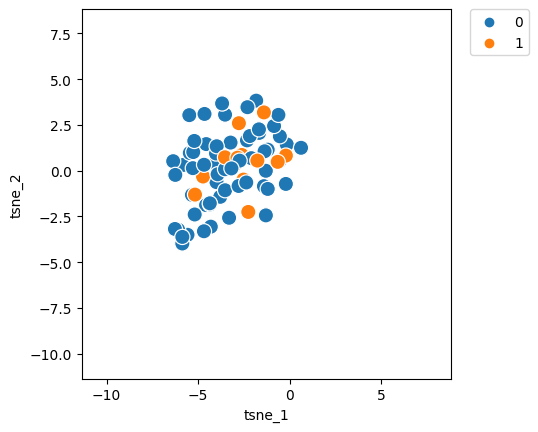

In [150]:
#concate_pred,d_out,phi=model()

data_orig=data.iloc[:,5:30]
labels=data.iloc[:,0]

# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(data_orig) #combined_features combined_transformed
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

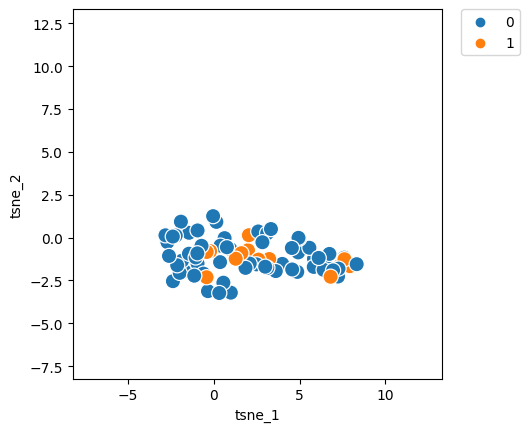

In [151]:
data_for_trans=data.iloc[:,5:30]
labels_for_trans=data.iloc[:,0]

data_tensor=torch.from_numpy(data_for_trans.to_numpy().astype(np.float32))
concate_pred,d_out,phi=model(data_tensor,0.5)

#data=data[:,5:30]
#labels=data[:,0]

# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(phi.detach().cpu().numpy()) #combined_features combined_transformed
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels_for_trans})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

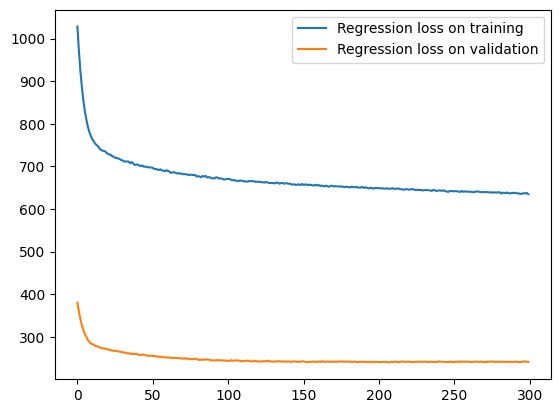

In [157]:
plt.plot(train_loss, label='Regression loss on training')
plt.plot(val_loss, label='Regression loss on validation')
plt.legend()
plt.show()

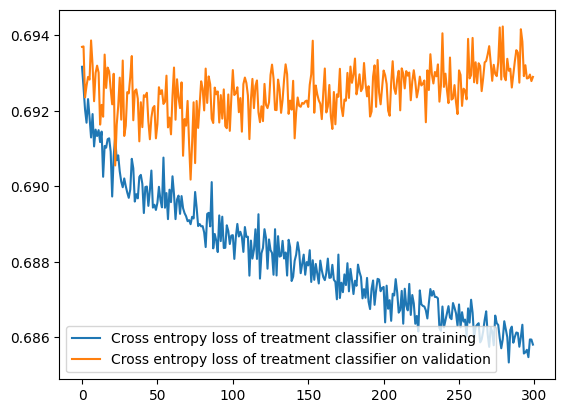

In [156]:
plt.plot(train_tloss,label='Cross entropy loss of treatment classifier on training')
plt.plot(val_tloss,label='Cross entropy loss of treatment classifier on validation')
plt.legend()
plt.show()

In [141]:
'''
full network origional with optuna

class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL32'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], params['CL22']), #
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], params['RG022']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], params['RG122']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        y1 = self.regressorO_y1(out_y1)

        concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        d_out = self.dis3_d(out_d2)

        concat = torch.cat((y0, y1), 1)
        return concat,d_out

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None




def objective(trial,i):

    params = {
          'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
          'batch_size':trial.suggest_int('batch_size', 8, 256),
          'RL11':trial.suggest_int('RL11', 16, 512),
          'RL21': trial.suggest_int('RL21', 16, 512),
          'RL32': trial.suggest_int('RL32', 16, 512),
          'RG012':trial.suggest_int('RG012', 16, 512),
        'RG022':trial.suggest_int('RG022', 16, 512),
        'RG112':trial.suggest_int('RG112', 16, 512),
        'RG122':trial.suggest_int('RG122', 16, 512),
        'CL12':trial.suggest_int('CL12', 16, 512),
        'CL22':trial.suggest_int('CL22', 16, 512)
          
          }

    model = TarNet(params)

    pehe,model= train_evaluate(params, model, trial,i)

    return pehe


'''

'\nfull network origional with optuna\n\nclass TarNet(nn.Module):\n    def __init__(self,params):\n        super(TarNet, self).__init__()\n        self.encoder1 = nn.Linear(25, params[\'RL11\'])\n        self.encoder2 = nn.Linear(params[\'RL11\'], params[\'RL21\'])\n        self.encoder3 = nn.Linear(params[\'RL21\'], params[\'RL32\'])\n        \n        self.dis1_d = nn.Sequential(\n            nn.Linear(params[\'RL32\'], params[\'CL12\']), #params[\'CL12\']\n            nn.ReLU(),\n            nn.Dropout(p=0.1)\n        )\n        self.dis2_d = nn.Sequential(\n            nn.Linear(params[\'CL12\'], params[\'CL22\']), #\n            nn.ReLU(),\n            nn.Dropout(p=.01)\n        )\n        \n        self.dis3_d = nn.Sequential(\n            nn.Linear(params[\'CL22\'], 2),\n            nn.ReLU(),\n            nn.Dropout(p=.01)\n        )\n       \n        \n        self.regressor1_y0 = nn.Sequential(\n            nn.Linear(params[\'RL32\'], params[\'RG012\']),\n            nn.ELU()

In [ ]:
'''
Library way: all networks have two layers 
1.38

class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL21'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], 2), #params['CL22']
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL21'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], 1),#params['RG022']
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL21'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], 1), #params['RG122']
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        #phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        #y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        #y1 = self.regressorO_y1(out_y1)

        #concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        #d_out = self.dis3_d(out_d2)

        concat = torch.cat((out_y0, out_y1), 1)
        return concat,out_d2

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None

'''



In [ ]:
'''
Tutorial way: layers and neurons all changed

class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL32'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], params['CL22']), #
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], 1), #params['RG022']
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], 1), #params['RG122']
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        #phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        #y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        #y1 = self.regressorO_y1(out_y1)

        concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        d_out = self.dis3_d(out_d2)

        concat = torch.cat((out_y0, out_y1), 1)
        return concat,d_out

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None




def objective(trial,i):

    params = {
          'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
          'batch_size':trial.suggest_int('batch_size', 8, 256),
          'RL11':trial.suggest_int('RL11', 16, 32),
          'RL21': trial.suggest_int('RL21', 16, 32),
          'RL32': trial.suggest_int('RL32', 16, 32),
          'RG012':trial.suggest_int('RG012', 16, 32),
        'RG022':trial.suggest_int('RG022', 16, 32),
        'RG112':trial.suggest_int('RG112', 16, 32),
        'RG122':trial.suggest_int('RG122', 16, 32),
        'CL12':trial.suggest_int('CL12', 16, 32),
        'CL22':trial.suggest_int('CL22', 16, 32)
          
          }

    model = TarNet(params)

    pehe,model= train_evaluate(params, model, trial,i)

    return pehe


'''

In [ ]:
'''
result 0.71 seed=42, result 0.79 seed=0, result 0.72 seed=1
one change: with 2 layers of classifier

class TarNet(nn.Module):
    def __init__(self,params):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(25, params['RL11'])
        self.encoder2 = nn.Linear(params['RL11'], params['RL21'])
        self.encoder3 = nn.Linear(params['RL21'], params['RL32'])
        
        self.dis1_d = nn.Sequential(
            nn.Linear(params['RL32'], params['CL12']), #params['CL12']
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(params['CL12'], 2), #params['CL22']
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(params['CL22'], 2),
            nn.ReLU(),
            nn.Dropout(p=.01)
        )
       
        
        self.regressor1_y0 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG012']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(params['RG012'], params['RG022']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y0 = nn.Linear(params['RG022'], 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(params['RL32'], params['RG112']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(params['RG112'], params['RG122']),
            nn.ELU(),
            nn.Dropout(p=.01),
        )
        self.regressorO_y1 = nn.Linear(params['RG122'], 1)



    def forward(self, inputs,alpha=0.5):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        phi = nn.functional.elu(self.encoder3(phi))
        
        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        y1 = self.regressorO_y1(out_y1)

        #concat = torch.cat((y0, y1), 1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        #d_out = self.dis3_d(out_d2)

        concat = torch.cat((y0, y1), 1)
        return concat,out_d2

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None


'''